## Evidence analysis

The data used to simulate the QPO lightcurves.

|Parameter      |    $K_{rn}$ values   |    $K_{qpo + rn}$ values   |
|:--------------|:--------------------:|:--------------------------:|
|$a_{rn}$       |  exp(1)              |  exp(1)                    |
|$c_{rn}$       |  exp(1) $s^{-1}$     |  exp(1) $s^{-1}$           |
|$a_{qpo}$      |      -               |  exp(-2) or exp(-0.4)      |
|$c_{qpo}$      |      -               |  exp(1) $s^{-1}$           |
|$f_{qpo}$      |      -               |      20 Hz                 |
|A              |      3               |      3                     |
|$t_{0}$        |      0.5 s           |      0.5 s                 |
|$\sigma$       |      0.2 s           |      0.2 s                 |

We will simulate lightcurves and anlyse the evidences produced

In [4]:
# Dependancies

import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import tinygp
from tinygp import GaussianProcess, kernels
from stingray import Lightcurve
jax.config.update("jax_enable_x64", True)

import functools

In [32]:
# Mean Model

def gaussian(t, mean_params):
    return mean_params["A"] * jnp.exp(-((t - mean_params["t0"])**2)/(2*(mean_params["sig"]**2)))

# Build Gp
def build_gp(kernel_params, mean_params, t, kernel_type, mean_type = "gaussian"):
    if kernel_type == "QPO_plus_RN":
        kernel = kernels.quasisep.Exp(
                scale = 1/kernel_params["crn"], sigma = (kernel_params["arn"])**0.5) + kernels.quasisep.Celerite(
                a = kernel_params["aqpo"], b = 0.0, c = kernel_params["cqpo"], d = kernel_params["freq"])
    elif kernel_type == "RN":
        kernel = kernels.quasisep.Exp(
                scale = 1/kernel_params["crn"], sigma = (kernel_params["arn"])**0.5)
    
    # Using partial to make the mean so that it only takes the time value
    if mean_type == "gaussian":
        mean = functools.partial(gaussian, mean_params = mean_params)
        return tinygp.GaussianProcess(kernel, t, mean=mean)
    elif mean_type == "constant":
        mean = mean_params
        return tinygp.GaussianProcess(kernel, t)
    # return tinygp.GaussianProcess(
    #     kernel, t, mean=mean
    # )

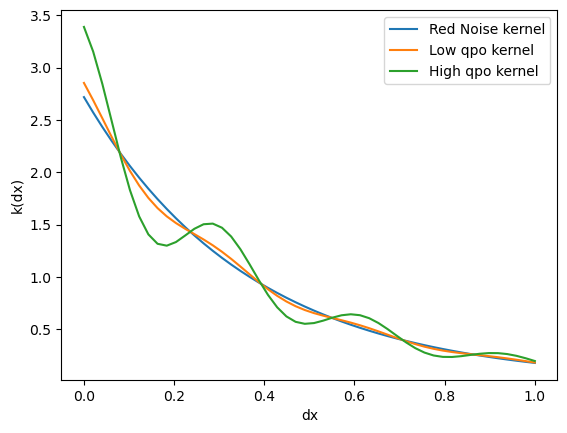

In [25]:
def plot_kernel(kernel, **kwargs):
    """ A function to plot the kernel"""
    dx = np.linspace(0, 1, 50)
    plt.plot(dx, kernel(dx, dx[:1]), **kwargs)
    # print(kernel(dx, dx[:1]))
    plt.xlabel("dx")
    plt.legend()
    plt.ylabel("k(dx)")

rnparams = {
    "arn": jnp.exp(1.0),    "crn": jnp.exp(1.0),
    "aqpo": 0.0,    "cqpo": 0.0,    "freq": 0.0
}

rnkernel = kernels.quasisep.Exp(
                scale = 1/rnparams["crn"], sigma = (rnparams["arn"])**0.5)

lqpoparams = {
    "arn" : jnp.exp(1.0),   "crn" : jnp.exp(1.0),
    "aqpo": jnp.exp(-2),   "cqpo": jnp.exp(1),    "freq": 20
}

lqpokernel = kernels.quasisep.Exp(
    scale = 1/lqpoparams["crn"], sigma = (lqpoparams["arn"])**0.5) + kernels.quasisep.Celerite(
        a = lqpoparams["aqpo"], b = 0.0, c = lqpoparams["cqpo"], d = lqpoparams["freq"])

hqpoparams = {
    "arn" : jnp.exp(1.0),    "crn" : jnp.exp(1.0),
    "aqpo": jnp.exp(-0.4),    "cqpo": jnp.exp(1),    "freq": 20,
}

hqpokernel = kernels.quasisep.Exp(
    scale = 1/hqpoparams["crn"], sigma = (hqpoparams["arn"])**0.5) + kernels.quasisep.Celerite(
        a = hqpoparams["aqpo"], b = 0.0, c = hqpoparams["cqpo"], d = hqpoparams["freq"])

plot_kernel(rnkernel, label="Red Noise kernel")
plot_kernel(lqpokernel, label="Low qpo kernel")
plot_kernel(hqpokernel, label="High qpo kernel")

Text(0, 0.5, 'M(x)')

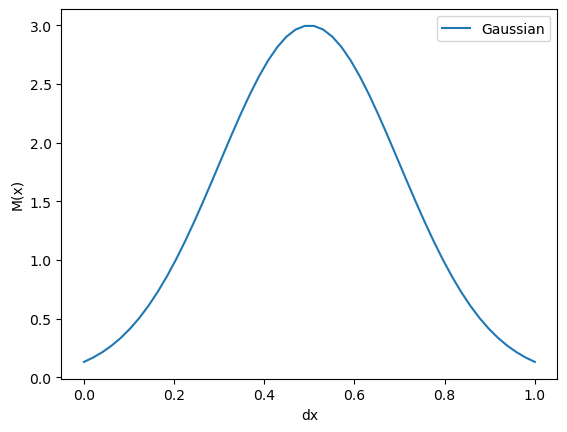

In [26]:
# Plotting the mean function:-
mean_params = {
    "A" : 3,    "t0" : 0.5,    "sig" : 0.2,
}

gaussian2 = functools.partial(gaussian, mean_params = mean_params)

dx = np.linspace(0, 1, 50)
plt.plot(dx, gaussian2(dx), label = "Gaussian")
plt.xlabel("dx")
plt.legend()
plt.ylabel("M(x)")

In [27]:
# MAKING THE SIMULATION

Times = np.linspace(0,1,256)  # 1 secound lightcurve with 256 points

rngp = build_gp(rnparams, mean_params, Times, kernel_type = "RN")
lqpogp = build_gp(lqpoparams, mean_params, Times, kernel_type = "QPO_plus_RN")
hqpogp = build_gp(hqpoparams, mean_params, Times, kernel_type = "QPO_plus_RN")

Text(0.5, 0, 'x')

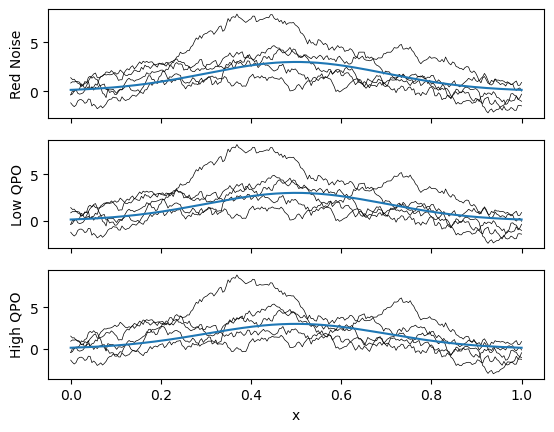

In [28]:
# Taking samples and plotting them
rngp_sample = rngp.sample(jax.random.PRNGKey(4), shape=(5,))
lqpogp_sample = lqpogp.sample(jax.random.PRNGKey(4), shape=(5,))
hqpogp_sample = hqpogp.sample(jax.random.PRNGKey(4), shape=(5,))

# Plotting these samples
_, axes = plt.subplots(3, 1, sharex=True)
ax = axes[0]
ax.plot(Times, rngp_sample.T, color="k", lw=0.5)
ax.plot(Times, jax.vmap(gaussian2)(Times), label="mean")
ax.set_ylabel("Red Noise")

ax = axes[1]
ax.plot(Times, lqpogp_sample.T, color="k", lw=0.5)
ax.plot(Times, jax.vmap(gaussian2)(Times), label="mean")
ax.set_ylabel("Low QPO")

ax = axes[2]
ax.plot(Times, hqpogp_sample.T, color="k", lw=0.5)
ax.plot(Times, jax.vmap(gaussian2)(Times), label="mean")
ax.set_ylabel("High QPO")

ax.set_xlabel("x")

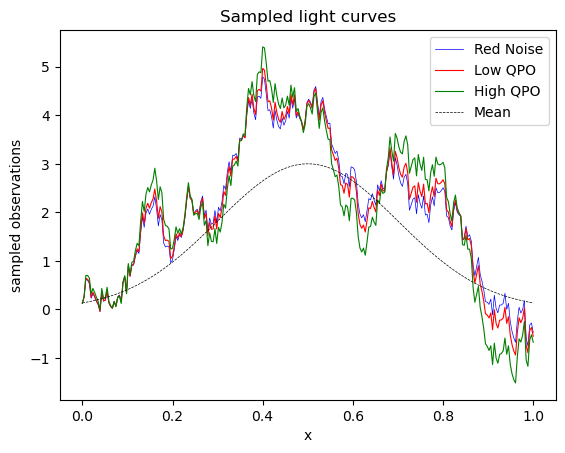

In [29]:
rngp_sample2   =  rngp.sample( jax.random.PRNGKey(2), shape=(1,))
lqpogp_sample2 = lqpogp.sample(jax.random.PRNGKey(2), shape=(1,))
hqpogp_sample2 = hqpogp.sample(jax.random.PRNGKey(2), shape=(1,))

plt.plot(Times, rngp_sample2.T, lw=0.5,color = "b" ,label = "Red Noise")
plt.plot(Times, lqpogp_sample2.T, lw=0.8, color = "r", label = "Low QPO")
plt.plot(Times, hqpogp_sample2.T, lw=0.8, color = "g", label = "High QPO")
plt.plot(Times, gaussian2(Times), color = "k", lw=0.5, ls = "--", label = "Mean")
plt.xlabel("x")
plt.ylabel("sampled observations")
plt.legend()
_ = plt.title("Sampled light curves")

# this evidence is correct as this lightcurve does not look like a qpo lightcurve

Making fig 1 from morris paper

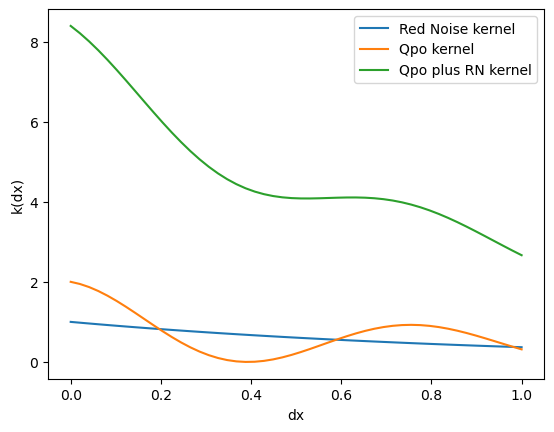

In [30]:
M_rnparams = {
    "arn": 1.0,    "crn": 1.0,
    "aqpo": 0.0,    "cqpo": 0.0,    "freq": 0.0
}

M_rnkernel = kernels.quasisep.Exp(
                scale = 1/M_rnparams["crn"], sigma = (M_rnparams["arn"])**0.5)

M_qpoparams = {
    "arn" : 1.0,   "crn" : 1.0,
    "aqpo": 1.0,   "cqpo": 1.0,    "freq": 8
}

M_qpokernel = kernels.quasisep.Exp(
    scale = 1/M_qpoparams["crn"], sigma = (M_qpoparams["arn"])**0.5) + kernels.quasisep.Celerite(
        a = M_qpoparams["aqpo"], b = 0.0, c = M_qpoparams["cqpo"], d = M_qpoparams["freq"])

M_qpo_plus_rn_params = {
    "arn" : jnp.exp(2.0),    "crn" : 1.0,
    "aqpo": 1.0,   "cqpo": 1.0,    "freq": 8,
}

M_qpo_plus_rn_kernel = kernels.quasisep.Exp(
    scale = 1/M_qpo_plus_rn_params["crn"], sigma = (M_qpo_plus_rn_params["arn"])**0.5) + kernels.quasisep.Celerite(
        a = M_qpo_plus_rn_params["aqpo"], b = 0.0, c = M_qpo_plus_rn_params["cqpo"], d = M_qpo_plus_rn_params["freq"])

plot_kernel(M_rnkernel, label="Red Noise kernel")
plot_kernel(M_qpokernel, label="Qpo kernel")
plot_kernel(M_qpo_plus_rn_kernel, label="Qpo plus RN kernel")

Text(0.5, 0, 'x')

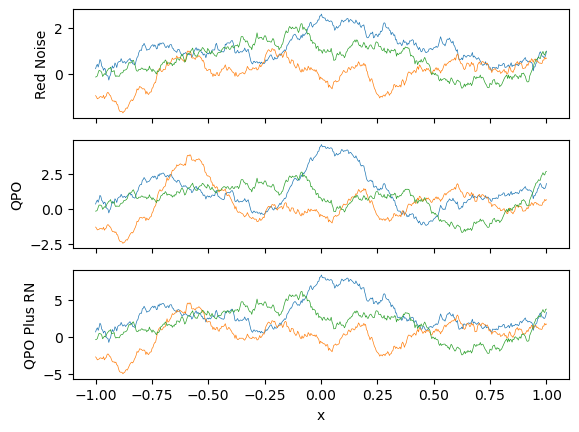

In [34]:
# MAKING THE SIMULATION

Times2 = np.linspace(-1,1,512)  # 1 secound lightcurve with 256 points

M_rn_gp = build_gp(M_rnparams, 0, Times2, kernel_type = "RN", mean_type = "constant")
M_qpo_gp = build_gp(M_qpoparams, 0, Times2, kernel_type = "QPO_plus_RN", mean_type = "constant")
M_qpo_plus_rn_gp = build_gp(M_qpo_plus_rn_params, 0, Times2, kernel_type = "QPO_plus_RN", mean_type = "constant")

# Taking samples and plotting them
M_rngp_sample = M_rn_gp.sample(jax.random.PRNGKey(4), shape=(3,))
M_qpogp_sample = M_qpo_gp .sample(jax.random.PRNGKey(4), shape=(3,))
M_qpo_plus_rn_qpogp_sample = M_qpo_plus_rn_gp.sample(jax.random.PRNGKey(4), shape=(3,))

# Plotting these samples
_, axes = plt.subplots(3, 1, sharex=True)
ax = axes[0]
ax.plot(Times2, M_rngp_sample.T, lw=0.5)
# ax.plot(Times, jax.vmap(gaussian2)(Times), label="mean")
ax.set_ylabel("Red Noise")

ax = axes[1]
ax.plot(Times2, M_qpogp_sample.T, lw=0.5)
# ax.plot(Times, jax.vmap(gaussian2)(Times), label="mean")
ax.set_ylabel("QPO")

ax = axes[2]
ax.plot(Times2, M_qpo_plus_rn_qpogp_sample.T, lw=0.5)
# ax.plot(Times, jax.vmap(gaussian2)(Times), label="mean")
ax.set_ylabel("QPO Plus RN")

ax.set_xlabel("x")

The text for the image is as follows:-
Realisations of GPs with a red noise krn (top left), quasi-periodic kqpo (middle left), and combined red noise and quasi-periodic kqpo+rn kernels (bottom left). The figures on the right are the corresponding power spectra to the time series on the left. We set aqpo = arn = cqpo = crn = 1 and fqpo = 8 in the first and second panel, and use the same parameters except for arn = exp(2) in the third panel

![Simulated Lightcurve](./Images/Simulated_lightcurves.png)